In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
SEED = 1380
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

In [4]:
data_directory = "Data/hcp_rest_and_motor/"

# List all files in the data directory
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

# Split the file names to extract the subject IDs
file_ids = [file.split('_')[0] for file in file_names]

# Define the split ratios (60% train, 20% validation, 20% test)
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Split the subject IDs into train, validation, and test sets
train_ids, test_and_val_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
validation_ids, test_ids = train_test_split(test_and_val_ids, test_size=0.5, random_state=1380)

# Create datasets for the training, validation, and test sets
train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
validation_dataset = FMRIConnectivityDataset(data_directory, validation_ids)
test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

# Dataloaders for training, validation, and test sets
batch_size = 21
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import random

def sample_fMRI_data(data_loader, data_type):
    """
    Sample a batch of fMRI data from a DataLoader for a specific data type.
    
    Args:
        data_loader (DataLoader): The DataLoader for the fMRI dataset.
        data_type (str): Either "rest" or "motor" to specify the data type.

    Returns:
        torch.Tensor: A batch of fMRI data for the specified data type.
    """
    batch = next(iter(data_loader))
    if data_type == "rest":
        fMRI_data = batch["rest_fMRI_data"]
    elif data_type == "motor":
        fMRI_data = batch["motor_task_fMRI_data"]
    else:
        raise ValueError("Invalid data type. Use 'rest' or 'motor'.")

    return fMRI_data

# Example usage in the training loop
X = sample_fMRI_data(train_data_loader, "rest")  # Sample resting state data
Y = sample_fMRI_data(train_data_loader, "motor")  # Sample motor task data

In [14]:
X.shape

torch.Size([21, 1, 400, 400])

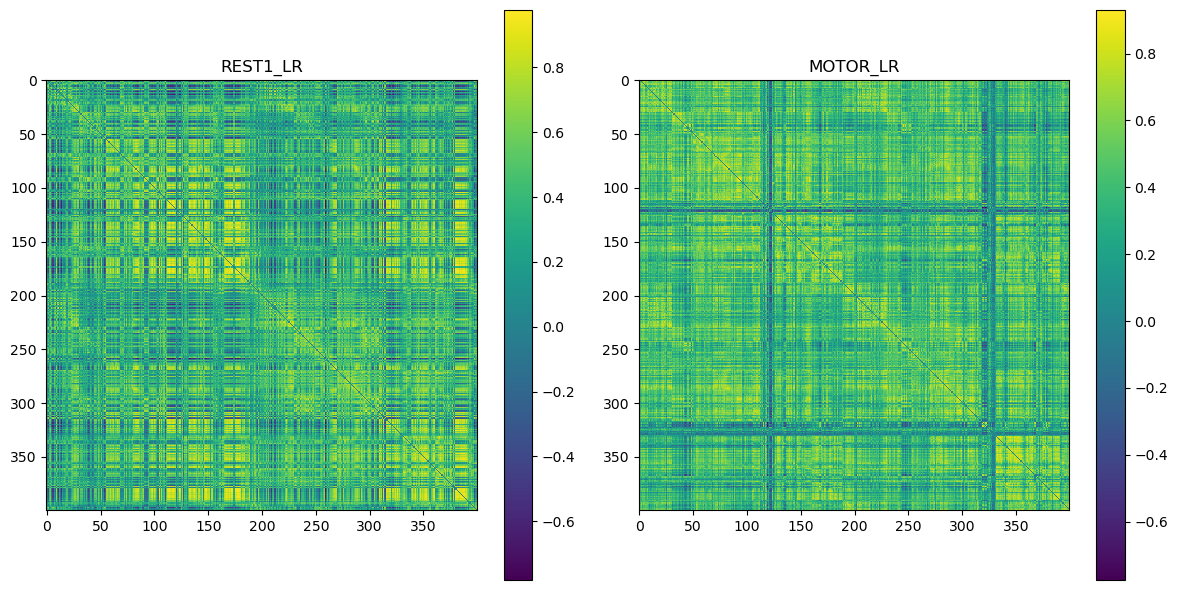

In [6]:
rest_data = np.loadtxt("Data/hcp_rest_and_motor/580751_rfMRI_REST1_LR.csv", delimiter=",", skiprows=1)
motor_data = np.loadtxt("Data/hcp_rest_and_motor/580751_tfMRI_MOTOR_LR.csv", delimiter=",", skiprows=1)

plt.figure(figsize=(12, 6)) 

# Heatmap for 580751_rfMRI_REST1_LR.csv
plt.subplot(1, 2, 1)
plt.imshow(rest_data, cmap='viridis', interpolation='nearest')
plt.title("REST1_LR")
plt.colorbar()

# Heatmap for 580751_rfMRI_MOTOR_LR.csv
plt.subplot(1, 2, 2)
plt.imshow(motor_data, cmap='viridis', interpolation='nearest')
plt.title("MOTOR_LR")
plt.colorbar()

plt.tight_layout()  
plt.show()

## NOT part

In [7]:
import torch.nn as nn

# Transport model T
T = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 1, kernel_size=5, padding=2), 
).to(DEVICE)

# Mapping model f
f = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  # 128 x 8 x 8
    nn.Conv2d(128, 256, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  # 256 x 4 x 4
    nn.Conv2d(256, 512, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  # 512 x 2 x 2
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.ReLU(True),
    nn.AvgPool2d(2),  # 512 x 1 x 1
    nn.Conv2d(512, 1, kernel_size=1, padding=0),
    nn.Flatten(1),
).to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))


T params: 2055169
f params: 6460417


### STRONG cost

In [8]:
def sq_cost (X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

COST = sq_cost

In [9]:
COST = sq_cost

# Other parameters
T_ITERS = 10
MAX_STEPS = 10000 + 1

## NOT algorithm

In [10]:
MAX_STEPS = 200
T.train(True)
f.eval() 

for step in tqdm(range(MAX_STEPS)):
    for t_iter in range(T_ITERS):
        X = sample_fMRI_data(train_data_loader, "rest")
        X = torch.tensor(X, device=DEVICE)
        
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    X, Y = sample_fMRI_data(train_data_loader, "rest"), sample_fMRI_data(train_data_loader, "motor")
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - f(Y).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)
        plot_results()  

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\cnbr\AppData\Local\Temp\ipykernel_23456\1794151104.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=DEVICE)


KeyboardInterrupt: 